In [14]:
#import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle


# Import Dataset

In [15]:
# import dataset
df=pd.read_csv('Copy of Microsoft x Carsome Hackathon Auction Data Set - fancy-adventurous-peacock-62328.csv')

In [16]:
df.head()

,lead_id,marketplace_id,marketplace_car_id,used_dealer_company_id,dealer_id,car_brand,car_model,car_variant,car_engine,car_year,car_transmission,reserveprice
0,928320,141263,292354,4620.0,4728,honda,freed,s,1.5,2012,Auto,85000000
1,944610,141300,299526,5033.0,5141,honda,city,vtec,1.5,2011,Auto,95000000
2,929573,141255,290464,4471.0,4579,honda,hr-v,s,1.5,2016,Auto,139000000
3,942475,141290,297815,4697.0,4805,suzuki,ertiga,gl,1.4,2016,Manual,115000000
4,926113,141273,294157,4351.0,4459,suzuki,ertiga,gx,1.4,2014,Manual,85000000


# Data Preprocessing

In [17]:
# check for missing data
df.isnull().any(axis=0)

lead_id                   False
marketplace_id            False
marketplace_car_id        False
used_dealer_company_id     True
dealer_id                 False
car_brand                 False
car_model                 False
car_variant                True
car_engine                 True
car_year                  False
car_transmission          False
reserveprice              False
dtype: bool

In [18]:
# replace for the missing data
df['car_variant']=df['car_variant'].fillna('no variant')
df['used_dealer_company_id']=df['used_dealer_company_id'].fillna(999999)

# remove null
df=df.dropna()

## Encode Categorical Data

In [19]:
#create a dictionary to determine ranking of brand, model, and variant
carbrand_transform= (df.groupby('car_brand')['reserveprice']
              .mean()
              .sort_values()
              .rank(method='dense', ascending=True)
              .astype(int)
              .to_dict())

carmodel_transform=(df.groupby('car_model')['reserveprice']
              .mean()
              .sort_values()
              .rank(method='dense', ascending=True)
              .astype(int)
              .to_dict())
carvariant_transform = (df.groupby('car_variant')['reserveprice']
              .mean()
              .sort_values()
              .rank(method='dense', ascending=True)
              .astype(int)
              .to_dict())

In [20]:
# Use frequency to encode the ids
lead_frequency_map=df['lead_id'].value_counts().to_dict()
mp_frequency_map=df['marketplace_id'].value_counts().to_dict()
mpc_frequency_map=df['marketplace_car_id'].value_counts().to_dict()
udc_frequency_map=df['used_dealer_company_id'].value_counts().to_dict()
dealer_frequency_map=df['dealer_id'].value_counts().to_dict()

In [31]:
# expeort to csv file
lead_df = pd.DataFrame.from_dict(lead_frequency_map, orient='index', columns=['lead_frequency'])
mp_df = pd.DataFrame.from_dict(mp_frequency_map, orient='index', columns=['mp_frequency'])
mpc_df = pd.DataFrame.from_dict(mpc_frequency_map, orient='index', columns=['mpc_frequency'])
udc_df = pd.DataFrame.from_dict(udc_frequency_map, orient='index', columns=['udc_frequency'])
dealer_df = pd.DataFrame.from_dict(dealer_frequency_map, orient='index', columns=['dealer_frequency'])
carbrand_df = pd.DataFrame.from_dict(carbrand_transform, orient='index', columns=['car_brand_rank'])
carmodel_df = pd.DataFrame.from_dict(carmodel_transform, orient='index', columns=['car_model_rank'])
carvariant_df = pd.DataFrame.from_dict(carvariant_transform, orient='index', columns=['car_variant_rank'])

# Export each DataFrame to a different sheet in the same CSV file
with pd.ExcelWriter('output.xlsx') as f:
    lead_df.to_excel(f, index_label='lead', sheet_name='lead')
    mp_df.to_excel(f, index_label='mp', sheet_name='mp')
    mpc_df.to_excel(f, index_label='mpc', sheet_name='mpc')
    udc_df.to_excel(f, index_label='udc', sheet_name='udc')
    dealer_df.to_excel(f, index_label='dealer', sheet_name='dealer')
    carbrand_df.to_excel(f, index_label='car_brand', sheet_name='car_brand')
    carmodel_df.to_excel(f, index_label='car_model', sheet_name='car_model')
    carvariant_df.to_excel(f, index_label='car_variant', sheet_name='car_variant')

In [8]:
# assign new  car brand, model, and variant
new_df=df.assign(car_brand=df['car_brand'].map(carbrand_transform), car_model=df['car_model'].map(carmodel_transform), car_variant=df['car_variant'].map(carvariant_transform))

# change auto to 0 and manual to 1
new_df['car_transmission'] = df['car_transmission'].replace({'Auto': 0, 'Manual': 1})
new_df.head()

# assign the ids from the encoding results
new_df['lead_id'], new_df['marketplace_id'], new_df['marketplace_car_id'], new_df['used_dealer_company_id'], new_df['dealer_id']=new_df['lead_id'].map(lead_frequency_map), new_df['marketplace_id'].map(mp_frequency_map), new_df['marketplace_car_id'].map(mpc_frequency_map), new_df['used_dealer_company_id'].map(udc_frequency_map), new_df['dealer_id'].map(dealer_frequency_map)

new_df.head()

,lead_id,marketplace_id,marketplace_car_id,used_dealer_company_id,dealer_id,car_brand,car_model,car_variant,car_engine,car_year,car_transmission,reserveprice
0,11,978,6,174,169,16,74,198,1.5,2012,0,85000000
1,29,1409,23,395,393,16,56,35,1.5,2011,0,95000000
2,68,883,61,1366,1362,16,128,198,1.5,2016,0,139000000
3,47,742,43,403,400,6,75,96,1.4,2016,1,115000000
4,27,759,24,782,781,6,75,111,1.4,2014,1,85000000


## Data Transformation

array([[<Axes: title={'center': 'lead_id'}>,
        <Axes: title={'center': 'marketplace_id'}>,
        <Axes: title={'center': 'marketplace_car_id'}>],
       [<Axes: title={'center': 'used_dealer_company_id'}>,
        <Axes: title={'center': 'dealer_id'}>,
        <Axes: title={'center': 'car_brand'}>],
       [<Axes: title={'center': 'car_model'}>,
        <Axes: title={'center': 'car_variant'}>,
        <Axes: title={'center': 'car_engine'}>],
       [<Axes: title={'center': 'car_year'}>,
        <Axes: title={'center': 'car_transmission'}>,
        <Axes: title={'center': 'reserveprice'}>]], dtype=object)

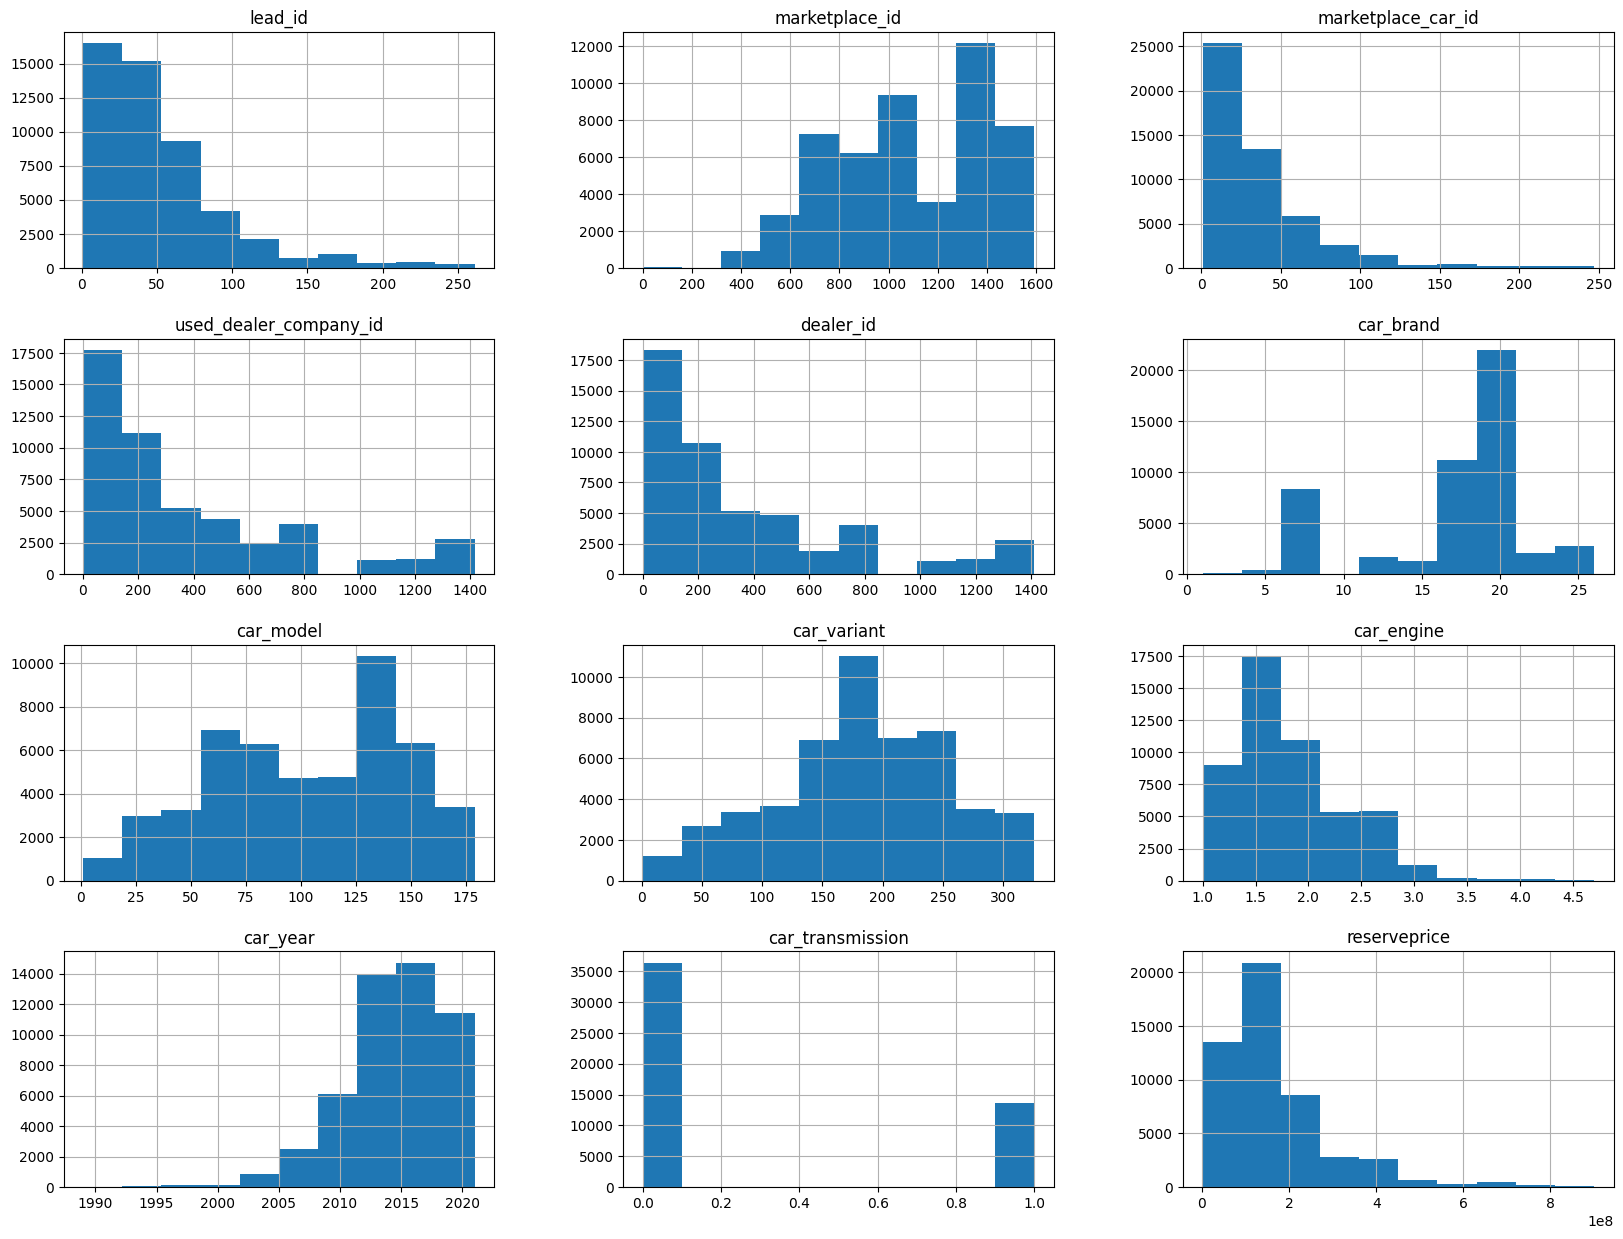

In [9]:
# check for skewness in data
new_df.hist(figsize= (20,15))

In [10]:
# Log Transform
new_df['lead_id']=np.log(new_df['lead_id'])
new_df['marketplace_id']=np.log(new_df['marketplace_id'])
new_df['marketplace_car_id']=np.log(new_df['marketplace_car_id'])
new_df['used_dealer_company_id']=np.log(new_df['used_dealer_company_id'])
new_df['dealer_id']=np.log(new_df['dealer_id'])
new_df['car_year']=np.log(new_df['car_year'])


# Data Split

In [11]:
# input variables
X= new_df.drop(['reserveprice'],axis = 1)

# target variable
y= new_df['reserveprice']

In [12]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# Model Training

In [13]:
# train with random forest regressor

rf= RandomForestRegressor()

rf.fit(X_train, y_train)

RandomForestRegressor()

In [45]:
# model score
rf.score(X_test, y_test)

0.9202935110866022

In [47]:
# optimize model

from sklearn.model_selection import GridSearchCV


param_grid={
    "n_estimators": [30, 50,100],
    "max_features": [4],
    "min_samples_split": [2,4,8],
    "max_depth": [None, 4, 8]
    
}

grid_search = GridSearchCV(rf, param_grid, cv=5,
                          scoring ="neg_mean_squared_error",
                          return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 4, 8], 'max_features': [4],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [30, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [49]:
best_rf=grid_search.best_estimator_

In [50]:
# optimized score
best_rf.score(X_test, y_test)

0.9256764623919049

# Make pickle file

In [ ]:
pickle.cump(best_rf, open("finalModel.pkl", "wb")f)